In [108]:
%matplotlib inline

In [109]:
#import sys
#!{sys.executable} -m pip install pomegranate

In [110]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import *
import os
import math
from IPython.display import HTML
from IPython.display import Video

from scipy.signal import deconvolve
import pomegranate
from pomegranate import *

import json


In [288]:
bursts = pd.read_csv('data/Berrocal_particles_analysis.csv')

In [289]:
bursts

,nucleus_id,particle_id,set_id,ap_raw,ap_registered,xPos,yPos,stripe_id,inf_flag,time,fluo
0,1.0517,NaN,1,0.417799,0.412853,516.000000,1.000000,2.333333,NaN,0,0.0
1,1.0517,NaN,1,0.415974,0.411356,511.244165,1.755835,2.333333,NaN,20,0.0
2,1.0517,NaN,1,0.414500,0.410133,507.621081,8.410272,2.000000,NaN,40,0.0
3,1.0517,NaN,1,0.414155,0.410011,507.000000,16.266675,2.000000,NaN,60,0.0
4,1.0517,NaN,1,0.414665,0.410521,508.508430,21.016861,2.000000,NaN,80,0.0
...,...,...,...,...,...,...,...,...,...,...,...
430068,11.1492,NaN,11,0.274391,0.290641,201.953329,256.000000,1.000000,NaN,2720,0.0
430069,11.1492,NaN,11,0.274822,0.291048,203.142525,256.000000,1.000000,NaN,2740,0.0
430070,11.1492,NaN,11,0.275375,0.291569,204.667895,256.000000,1.000000,NaN,2760,0.0
430071,11.1492,NaN,11,0.276047,0.292204,206.522067,256.000000,1.000000,NaN,2780,0.0


In [319]:
bpt = bursts.pivot_table(index=['particle_id'],columns=['time'],values=['fluo'])
bpt.fillna(0)

fluo                                                               \
time        60   80   100  120  140  160         180         200         220    
particle_id                                                                     
1.0163       0.0  0.0  0.0  0.0  0.0  0.0  74245.7306  30713.9331  11364.3210   
1.0164       0.0  0.0  0.0  0.0  0.0  0.0  26256.9493  26122.1896  31395.2833   
1.0166       0.0  0.0  0.0  0.0  0.0  0.0      0.0000      0.0000  42637.8032   
1.0167       0.0  0.0  0.0  0.0  0.0  0.0      0.0000      0.0000      0.0000   
1.0168       0.0  0.0  0.0  0.0  0.0  0.0      0.0000      0.0000      0.0000   
...          ...  ...  ...  ...  ...  ...         ...         ...         ...   
11.0598      0.0  0.0  0.0  0.0  0.0  0.0      0.0000      0.0000      0.0000   
11.0600      0.0  0.0  0.0  0.0  0.0  0.0      0.0000      0.0000      0.0000   
11.0601      0.0  0.0  0.0  0.0  0.0  0.0      0.0000      0.0000      0.0000   
11.0604      0.0  0.0  0.0  0.0  0.0  0.0      0.0000      0.0000      0.0000   
11.0605      0.0  0.0  0.0  0.0  0.0  0.0      0.0000      0.0000      0.0000   

                         ...                                         \
time               240   ...         2820         2840         2860   
particle_id              ...                                          
1.0163           0.0000  ...  260936.2200  258995.2460  301150.0470   
1.0164       43015.4975  ...       0.0000       0.0000       0.0000   
1.0166       16406.4213  ...       0.0000       0.0000       0.0000   
1.0167           0.0000  ...       0.0000       0.0000       0.0000   
1.0168           0.0000  ...       0.0000       0.0000       0.0000   
...                 ...  ...          ...          ...          ...   
11.0598          0.0000  ...   43196.4940   43292.3040   38390.8531   
11.0600          0.0000  ...  142383.5970  171419.3690  200036.5750   
11.0601          0.0000  ...  116626.4790  116453.5890  101712.9950   
11.0604          0.0000  ...   36223.9195   25650.3908   33446.7556   
11.0605          0.0000  ...       0.0000       0.0000       0.0000   

                                                                              \
time                2880         2900         2920         2940         2960   
particle_id                                                                    
1.0163       267472.8420  239776.3610  247126.7480  229798.6230  200913.3240   
1.0164            0.0000       0.0000       0.0000       0.0000       0.0000   
1.0166            0.0000       0.0000       0.0000       0.0000       0.0000   
1.0167            0.0000       0.0000       0.0000       0.0000       0.0000   
1.0168            0.0000       0.0000       0.0000       0.0000       0.0000   
...                  ...          ...          ...          ...          ...   
11.0598       32834.2505   25762.9146       0.0000       0.0000       0.0000   
11.0600      236360.5790  214088.1430  287176.0610  295473.3550  311125.6050   
11.0601      108206.8400  104759.9210   93146.7203   89492.7312   78672.7040   
11.0604       28690.9126   23935.0696   24834.7595   44089.8623   55358.4483   
11.0605       52892.8018   70738.5475   74373.7383   54902.3073   42919.1580   

                               
time                2980 3000  
particle_id                    
1.0163       166124.9200  0.0  
1.0164            0.0000  0.0  
1.0166            0.0000  0.0  
1.0167            0.0000  0.0  
1.0168            0.0000  0.0  
...                  ...  ...  
11.0598           0.0000  0.0  
11.0600      265477.3120  0.0  
11.0601           0.0000  0.0  
11.0604       52932.6274  0.0  
11.0605       54122.3257  0.0  

[2526 rows x 148 columns]

In [293]:
bursts['particle_id'].unique()

array([ 1.0163,  1.0164,  1.0166, ..., 11.0604, 11.0605,     nan])

In [294]:
bursts[bursts.particle_id == 1.0166]

,nucleus_id,particle_id,set_id,ap_raw,ap_registered,xPos,yPos,stripe_id,inf_flag,time,fluo
21137,1.0739,1.0166,1,0.255455,0.260541,91.537921,30.134480,0.666667,1.0,220,42637.8032
21138,1.0739,1.0166,1,0.259148,0.264097,101.295556,32.255062,0.666667,1.0,240,16406.4213
21139,1.0739,1.0166,1,0.263387,0.268161,112.448337,33.444834,0.666667,1.0,260,0.0000
21140,1.0739,1.0166,1,0.267698,0.272295,123.768522,34.000000,0.666667,1.0,280,0.0000
21141,1.0739,1.0166,1,0.271545,0.275972,133.850945,34.000000,0.666667,1.0,300,0.0000
21142,1.0739,1.0166,1,0.273517,0.277857,139.013776,33.797245,1.000000,1.0,320,0.0000
21143,1.0739,1.0166,1,0.274911,0.279175,142.639591,33.072082,1.000000,1.0,340,0.0000
21144,1.0739,1.0166,1,0.275827,0.280051,145.038244,33.000000,1.000000,1.0,360,0.0000
21145,1.0739,1.0166,1,0.276197,0.280405,146.000000,32.776715,1.000000,1.0,380,0.0000
21146,1.0739,1.0166,1,0.276208,0.280402,146.000000,32.000000,1.000000,1.0,400,0.0000


In [296]:
sorted(bursts.time.unique())

[0,
 20,
 40,
 60,
 80,
 100,
 120,
 140,
 160,
 180,
 200,
 220,
 240,
 260,
 280,
 300,
 320,
 340,
 360,
 380,
 400,
 420,
 440,
 460,
 480,
 500,
 520,
 540,
 560,
 580,
 600,
 620,
 640,
 660,
 680,
 700,
 720,
 740,
 760,
 780,
 800,
 820,
 840,
 860,
 880,
 900,
 920,
 940,
 960,
 980,
 1000,
 1020,
 1040,
 1060,
 1080,
 1100,
 1120,
 1140,
 1160,
 1180,
 1200,
 1220,
 1240,
 1260,
 1280,
 1300,
 1320,
 1340,
 1360,
 1380,
 1400,
 1420,
 1440,
 1460,
 1480,
 1500,
 1520,
 1540,
 1560,
 1580,
 1600,
 1620,
 1640,
 1660,
 1680,
 1700,
 1720,
 1740,
 1760,
 1780,
 1800,
 1820,
 1840,
 1860,
 1880,
 1900,
 1920,
 1940,
 1960,
 1980,
 2000,
 2020,
 2040,
 2060,
 2080,
 2100,
 2120,
 2140,
 2160,
 2180,
 2200,
 2220,
 2240,
 2260,
 2280,
 2300,
 2320,
 2340,
 2360,
 2380,
 2400,
 2420,
 2440,
 2460,
 2480,
 2500,
 2520,
 2540,
 2560,
 2580,
 2600,
 2620,
 2640,
 2660,
 2680,
 2700,
 2720,
 2740,
 2760,
 2780,
 2800,
 2820,
 2840,
 2860,
 2880,
 2900,
 2920,
 2940,
 2960,
 2980,
 3000]

(array([33656., 43175., 44032., 44357., 44385., 44385., 44383., 44127.,
        43482., 44091.]),
 array([   0.,  300.,  600.,  900., 1200., 1500., 1800., 2100., 2400.,
        2700., 3000.]),
 <a list of 10 Patch objects>)

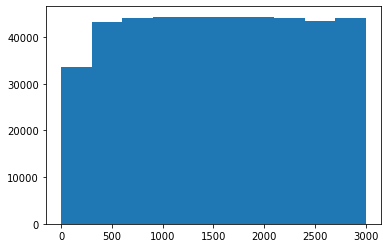

In [297]:
plt.hist(bursts.time)

In [290]:
bursts = bursts.sort_values(['particle_id','time'])

In [298]:
data = []

data.append([1,'A','True'])
data.append([2,'B','False'])
data.append([3,'C','Who Knows'])

df = pd.DataFrame(data=data,columns=['Number','Letter','Status'])

In [299]:
df

,Number,Letter,Status
0,1,A,True
1,2,B,False
2,3,C,Who Knows


In [301]:
bursts.particle_id.dropna().unique()

array([ 1.0163,  1.0164,  1.0166, ..., 11.0601, 11.0604, 11.0605])

In [302]:
data = []

for pid in sorted(list(bursts.particle_id.dropna().unique())):
    for time in sorted(list(bursts.time.unique())):
        data.append([pid,time])
        
bursts_filled = pd.DataFrame(data=data,columns=['particle_id','time'])



In [303]:
bursts_filled

,particle_id,time
0,1.0163,0
1,1.0163,20
2,1.0163,40
3,1.0163,60
4,1.0163,80
...,...,...
381421,11.0605,2920
381422,11.0605,2940
381423,11.0605,2960
381424,11.0605,2980


In [304]:
data = []

for pid in sorted(list(bursts.particle_id.dropna().unique())):
    for time in sorted(list(bursts.time.unique())):
        data.append([pid,time])
        
bursts_filled = pd.DataFrame(data=data,columns=['particle_id','time'])
bursts_filled = bursts_filled.merge(bursts,on=['particle_id','time'],how='left')
bursts_filled['fluo'] = bursts_filled['fluo'].fillna(0)

In [306]:
bursts_filled

,particle_id,time,nucleus_id,set_id,ap_raw,ap_registered,xPos,yPos,stripe_id,inf_flag,fluo
0,1.0163,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
1,1.0163,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
2,1.0163,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
3,1.0163,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
4,1.0163,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
381421,11.0605,2920,11.0928,11.0,0.450895,0.466063,688.000000,166.841396,3.0,0.0,74373.7383
381422,11.0605,2940,11.0928,11.0,0.451257,0.466494,689.000000,167.000000,3.0,0.0,54902.3073
381423,11.0605,2960,11.0928,11.0,0.451256,0.466493,689.000000,167.214768,3.0,0.0,42919.1580
381424,11.0605,2980,11.0928,11.0,0.451396,0.466665,689.399976,168.399976,3.0,0.0,54122.3257


In [308]:
bpt = bursts_filled.pivot_table(index=['particle_id'],columns=['time'],values=['fluo'])

In [320]:
bpt = bursts_filled.pivot_table(index=['particle_id'],columns=['time'],values=['fluo'])
bpt.columns = [c[1] for c in bpt.columns]
bpt_times = list(bpt.columns)

In [321]:
bpt

,0,20,40,60,80,100,120,140,160,180,...,2820,2840,2860,2880,2900,2920,2940,2960,2980,3000
particle_id,,,,,,,,,,,,,,,,,,,,,
1.0163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74245.7306,...,260936.2200,258995.2460,301150.0470,267472.8420,239776.3610,247126.7480,229798.6230,200913.3240,166124.9200,0.0
1.0164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26256.9493,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
1.0166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
1.0167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
1.0168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.0598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,43196.4940,43292.3040,38390.8531,32834.2505,25762.9146,0.0000,0.0000,0.0000,0.0000,0.0
11.0600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,142383.5970,171419.3690,200036.5750,236360.5790,214088.1430,287176.0610,295473.3550,311125.6050,265477.3120,0.0
11.0601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,116626.4790,116453.5890,101712.9950,108206.8400,104759.9210,93146.7203,89492.7312,78672.7040,0.0000,0.0


In [324]:
bpt = bpt.set_index('particle_id')

0                0.000000
20               0.000000
40               0.000000
60               0.000000
80               0.000000
                 ...     
2940         44089.862300
2960         55358.448300
2980         52932.627400
3000             0.000000
fluo_mean     2589.970862
Name: 11.0604, Length: 152, dtype: float64

In [322]:
bpt['fluo_mean'] = bpt[bpt_times].mean(axis=1)

(array([939., 630., 470., 266., 125.,  42.,  36.,  12.,   4.,   2.]),
 array([2.33326711e+02, 2.37408373e+04, 4.72483480e+04, 7.07558586e+04,
        9.42633692e+04, 1.17770880e+05, 1.41278390e+05, 1.64785901e+05,
        1.88293412e+05, 2.11800922e+05, 2.35308433e+05]),
 <a list of 10 Patch objects>)

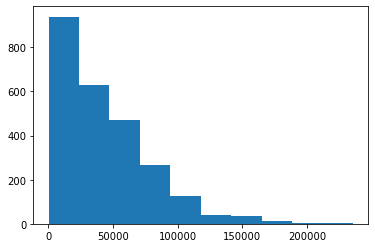

In [323]:
plt.hist(bpt['fluo_mean'])

In [118]:
test_burst = bpt[bpt_times].loc[1.0163].values

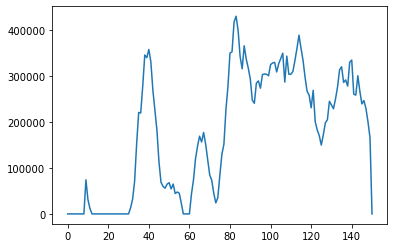

In [325]:
plt.plot(test_burst)

In [326]:
polymerase_transit_time = 7
polymerase_loading_rate = 40000

In [327]:
l = len(test_burst)

basis = np.zeros((l,l))

for i in range(0,l):
    np.put(
        basis[i],
        np.arange(i,min(i+polymerase_transit_time,l)),
        1)

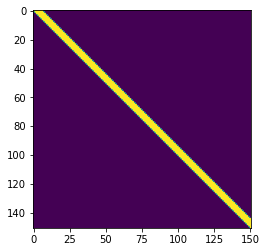

In [122]:
plt.imshow(basis)

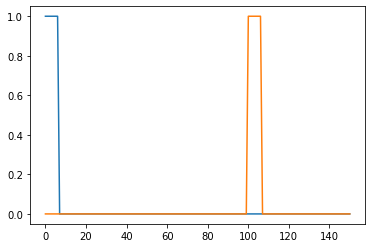

In [329]:
plt.plot(basis[0])
plt.plot(basis[100])

In [123]:
test_burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,test_burst)[0] / polymerase_loading_rate,np.ones(5)/5)

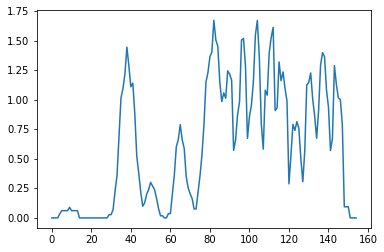

In [330]:
plt.plot(test_burst_nnls)

In [357]:
kon = .01
koff = .1

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

In [358]:
hmm_out = hmm.predict(test_burst_nnls, algorithm='viterbi')[1:]

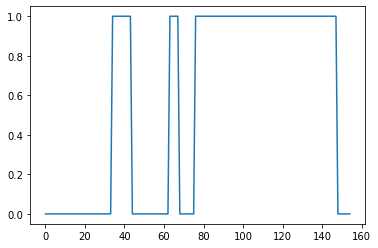

In [359]:
plt.plot(hmm_out)

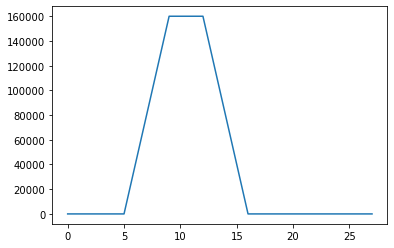

In [360]:
a = np.array([0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0])
b = polymerase_loading_rate * np.array([1,1,1,1,1,1,1])

out = np.convolve(a,b)
plt.plot(out)

In [361]:
hmm_out

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [362]:
polymerase_loading_rate * np.ones(7)

array([40000., 40000., 40000., 40000., 40000., 40000., 40000.])

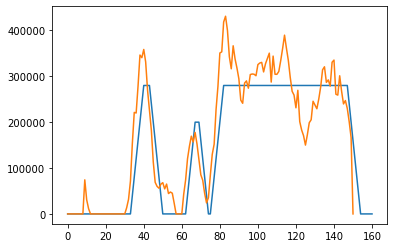

In [363]:
plt.plot(np.convolve(hmm_out,polymerase_loading_rate * np.ones(polymerase_transit_time)))
plt.plot(test_burst)

In [364]:
bursts_to_fit = bpt[bpt.fluo_mean > 50000][bpt_times].values

In [365]:
bursts_to_fit.shape

(903, 151)

In [366]:
burst_nnlss = []

for burst in bursts_to_fit:
    burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst)[0] / polymerase_loading_rate,np.ones(5)/5)
    burst_nnlss.append(burst_nnls[0:151])
    
burst_nnlss = np.array(burst_nnlss)

In [367]:
burst_nnlss.shape

(903, 151)

In [368]:
hmm_out  = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]



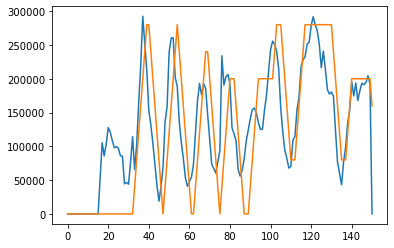

In [369]:
i = 12
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

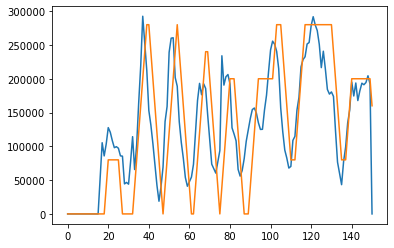

In [356]:
i = 12
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [133]:
hmm_dict['edges']

[[2, 0, 1.0, 1.0, None],
 [2, 1, 0.0, 0, None],
 [0, 0, 0.9, 0.9, None],
 [0, 1, 0.10000000000000003, 0.1, None],
 [1, 1, 0.9, 0.9, None],
 [1, 0, 0.10000000000000003, 0.1, None]]

In [370]:
hmm_fit = hmm.fit(burst_nnlss,algorithm='baum-welch')

In [371]:
hmm_fit_dict = json.loads(hmm.to_json())

In [372]:
hmm_fit_dict['edges']

[[2, 0, 1.0, 1.0, None],
 [2, 1, 0.0, 0, None],
 [0, 0, 0.9482229389469865, 0.99, None],
 [0, 1, 0.051777061053013565, 0.01, None],
 [1, 1, 0.9771094104473479, 0.9, None],
 [1, 0, 0.02289058955265205, 0.1, None]]

In [373]:
hmm_fit_dict

{'class': 'HiddenMarkovModel',
 'name': 'None',
 'start': {'class': 'State',
  'distribution': None,
  'name': 'None-start',
  'weight': 1.0},
 'end': {'class': 'State',
  'distribution': None,
  'name': 'None-end',
  'weight': 1.0},
 'states': [{'class': 'State',
   'distribution': {'class': 'Distribution',
    'name': 'NormalDistribution',
    'parameters': [1.4319028091978474e-17, 3.1395051748493556e-17],
    'frozen': False},
   'name': 'OFF',
   'weight': 1.0},
  {'class': 'State',
   'distribution': {'class': 'Distribution',
    'name': 'NormalDistribution',
    'parameters': [0.4589845299896991, 0.3570013434886361],
    'frozen': False},
   'name': 'ON',
   'weight': 1.0},
  {'class': 'State',
   'distribution': None,
   'name': 'None-start',
   'weight': 1.0},
  {'class': 'State', 'distribution': None, 'name': 'None-end', 'weight': 1.0}],
 'end_index': 3,
 'start_index': 2,
 'silent_index': 2,
 'edges': [[2, 0, 1.0, 1.0, None],
  [2, 1, 0.0, 0, None],
  [0, 0, 0.948222938946986

In [137]:
kon_fit = .0497
mean_on = 1/kon_fit
koff_fit = .0264
mean_off = 1/koff_fit
frac_on = mean_on / (mean_on + mean_off)

In [138]:
frac_on * polymerase_transit_time * polymerase_loading_rate

97135.3482260184

In [139]:
np.mean(bursts_to_fit)

81529.17868723182

In [140]:
polymerase_loading_rate = polymerase_loading_rate * np.mean(bursts_to_fit) / (frac_on * polymerase_transit_time * polymerase_loading_rate)

In [141]:
polymerase_loading_rate

33573.43343126808

In [374]:
burst_nnlss = []

for burst in bursts_to_fit:
    burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst)[0] / polymerase_loading_rate,np.ones(5)/5)
    burst_nnlss.append(burst_nnls)
    
burst_nnlss = np.array(burst_nnlss)

hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]

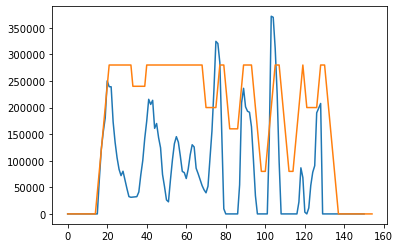

In [375]:
i = 10
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [376]:
kon = .1
koff = .1
polymerase_loading_rate = 33573
polymerase_transit_time = 7

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

In [377]:
hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]    
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]



In [146]:
from itertools import groupby

In [386]:
a = [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,2,2,2,2,2,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]

In [387]:
for i,r in groupby(a):
    print (i,len(list(r)))

0 4
1 8
0 5
2 5
0 6
1 5
0 12


In [388]:
runlens = [[],[]]

for d in hmm_out:
    for i,r in groupby(d):
        runlens[int(i)].append(len(list(r)))
        

In [390]:
runlens[1]

[10,
 5,
 44,
 27,
 5,
 18,
 5,
 5,
 29,
 6,
 3,
 7,
 15,
 12,
 3,
 6,
 5,
 15,
 4,
 29,
 8,
 12,
 5,
 19,
 4,
 5,
 3,
 6,
 16,
 5,
 5,
 4,
 6,
 5,
 6,
 5,
 5,
 3,
 27,
 11,
 2,
 5,
 5,
 14,
 8,
 4,
 10,
 11,
 39,
 4,
 3,
 5,
 6,
 10,
 4,
 17,
 7,
 9,
 3,
 5,
 5,
 6,
 4,
 9,
 41,
 3,
 2,
 8,
 7,
 6,
 5,
 5,
 9,
 20,
 5,
 5,
 7,
 3,
 5,
 21,
 5,
 4,
 11,
 27,
 6,
 5,
 8,
 7,
 13,
 13,
 5,
 3,
 18,
 14,
 16,
 5,
 5,
 17,
 9,
 34,
 11,
 5,
 5,
 5,
 5,
 13,
 22,
 14,
 3,
 11,
 5,
 9,
 38,
 10,
 5,
 5,
 8,
 13,
 30,
 5,
 4,
 12,
 13,
 8,
 4,
 6,
 5,
 6,
 5,
 4,
 8,
 5,
 14,
 2,
 4,
 15,
 4,
 5,
 2,
 2,
 11,
 8,
 8,
 14,
 8,
 12,
 6,
 13,
 11,
 7,
 5,
 12,
 6,
 8,
 10,
 12,
 12,
 12,
 5,
 6,
 8,
 8,
 6,
 4,
 21,
 4,
 5,
 5,
 5,
 6,
 5,
 3,
 6,
 7,
 19,
 20,
 5,
 8,
 3,
 18,
 12,
 5,
 6,
 14,
 14,
 28,
 14,
 6,
 5,
 12,
 7,
 3,
 6,
 11,
 11,
 12,
 13,
 14,
 6,
 3,
 8,
 45,
 19,
 3,
 15,
 35,
 16,
 29,
 4,
 5,
 12,
 7,
 3,
 6,
 10,
 21,
 4,
 5,
 5,
 3,
 17,
 10,
 23,
 2,
 5,
 15,
 10,
 6,
 6,


Mean Off:  22.063188022897403
Implied kon:  0.045324365588608036


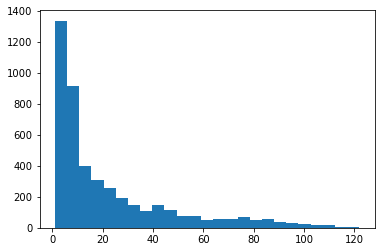

In [392]:
plt.hist(runlens[0],bins=25)
print ("Mean Off: " , np.mean(runlens[0]))
print ("Implied kon: ", 1/np.mean(runlens[0]))

Mean On:  10.912434806478178
Implied koff:  0.09163857725008803


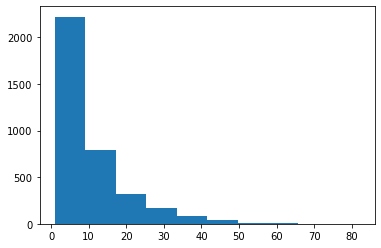

In [393]:
plt.hist(runlens[1])
print ("Mean On: " , np.mean(runlens[1]))
print ("Implied koff: ", 1/np.mean(runlens[1]))

In [394]:
kon = .05
koff = .09
polymerase_loading_rate = 33573
polymerase_transit_time = 7

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]

Mean Off:  22.063188022897403
Implied kon:  0.045324365588608036


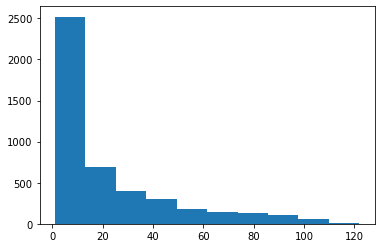

In [395]:
plt.hist(runlens[0])
print ("Mean Off: " , np.mean(runlens[0]))
print ("Implied kon: ", 1/np.mean(runlens[0]))

Mean On:  10.912434806478178
Implied koff:  0.09163857725008803


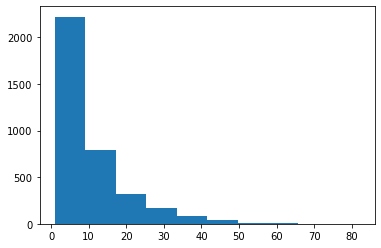

In [396]:
plt.hist(runlens[1])
print ("Mean On: " , np.mean(runlens[1]))
print ("Implied koff: ", 1/np.mean(runlens[1]))

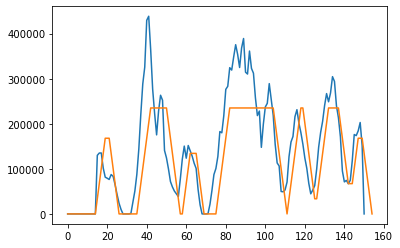

In [397]:
i = 4
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [154]:
kon = .05
koff = .08
polymerase_loading_rate = 33573
polymerase_transit_time = 7

# nnls

burst_nnlss = []

for burst in bursts_to_fit:
    burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst)[0] / polymerase_loading_rate,np.ones(5)/5)
    burst_nnlss.append(burst_nnls)
    
burst_nnlss = np.array(burst_nnlss)

# hmm

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]


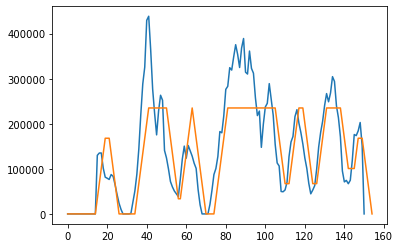

In [155]:
i = 4
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [156]:
polymerase_loading_rate * np.mean(bursts_to_fit) / (frac_on * polymerase_transit_time * polymerase_loading_rate)

33573.43343126808

In [405]:
kon = .05
koff = .09
polymerase_loading_rate = 35000
polymerase_transit_time = 10

l = bursts_to_fit.shape[1]

basis = np.zeros((l,l))

for i in range(0,l):
    np.put(
        basis[i],
        np.arange(i,min(i+polymerase_transit_time,l)),
        1)
    
    
# nnls

burst_nnlss = []

for burst in bursts_to_fit:
    burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst)[0] / polymerase_loading_rate,np.ones(5)/5)
    burst_nnlss.append(burst_nnls)
    
burst_nnlss = np.array(burst_nnlss)

# hmm

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]
    
    



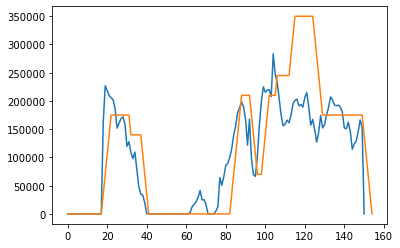

In [408]:
i = 20
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [410]:
bursts_to_fit = bpt[bpt_times].values
bursts_to_fit_ids = bpt.index

In [417]:
bursts_to_fit_ids

Float64Index([            1.0163,             1.0164,             1.0166,
                          1.0167,             1.0168,             1.0169,
              1.0170000000000001,             1.0172,             1.0173,
                          1.0174,
              ...
              11.059000000000001,            11.0591,            11.0592,
                         11.0594,            11.0595,            11.0598,
                           11.06,            11.0601,            11.0604,
                         11.0605],
             dtype='float64', name='particle_id', length=2526)

In [411]:
kon = .05
koff = .09
polymerase_loading_rate = 35000
polymerase_transit_time = 10

l = bursts_to_fit.shape[1]

basis = np.zeros((l,l))

for i in range(0,l):
    np.put(
        basis[i],
        np.arange(i,min(i+polymerase_transit_time,l)),
        1)
    
    
# nnls

burst_nnlss = []

for burst in bursts_to_fit:
    burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst)[0] / polymerase_loading_rate,np.ones(5)/5)
    burst_nnlss.append(burst_nnls)
    
burst_nnlss = np.array(burst_nnlss)

# hmm

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]

Mean Off:  22.063188022897403
Implied kon:  0.045324365588608036


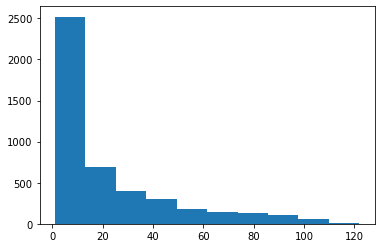

In [412]:
plt.hist(runlens[0])
print ("Mean Off: " , np.mean(runlens[0]))
print ("Implied kon: ", 1/np.mean(runlens[0]))

Mean On:  10.912434806478178
Implied koff:  0.09163857725008803


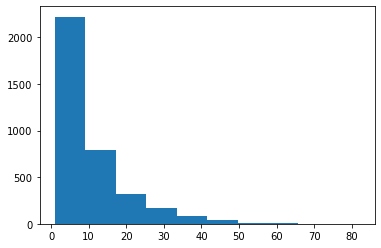

In [413]:
plt.hist(runlens[1])
print ("Mean On: " , np.mean(runlens[1]))
print ("Implied koff: ", 1/np.mean(runlens[1]))

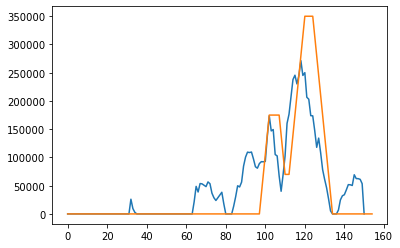

In [416]:
i = 250
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [184]:
bursts

,nucleus_id,particle_id,set_id,ap_raw,ap_registered,xPos,yPos,stripe_id,inf_flag,time,fluo
459,1.0520,1.0163,1,0.287726,0.290066,179.465698,122.691788,1.000000,1.0,180,74245.7306
460,1.0520,1.0163,1,0.285083,0.287585,172.610580,124.755768,1.000000,1.0,200,30713.9331
461,1.0520,1.0163,1,0.284553,0.287095,171.268960,126.067240,1.000000,1.0,220,11364.3210
462,1.0520,1.0163,1,0.286644,0.289101,176.785432,127.000000,1.000000,1.0,240,0.0000
463,1.0520,1.0163,1,0.290501,0.292744,186.893170,127.000000,1.000000,1.0,260,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
335239,9.1587,NaN,9,0.352549,0.367558,427.000000,9.000000,1.666667,NaN,3000,0.0000
335489,9.1600,NaN,9,0.390414,0.406838,526.000000,1.000000,2.333333,NaN,3000,0.0000
336523,9.1647,NaN,9,0.492639,0.498860,784.373896,224.626104,3.333333,NaN,3000,0.0000
336633,9.1653,NaN,9,0.344928,0.352584,401.373896,167.626104,1.666667,NaN,3000,0.0000


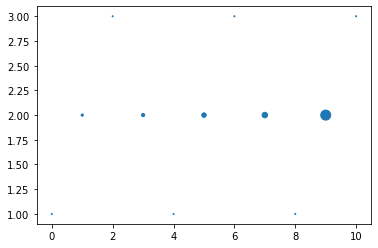

In [201]:
x = [0,1,2,3,4,5,6,7,8,9,10]
y = [1,2,3,2,1,2,3,2,1,2,3]
s = [1,5,1,10,1,20,1,30,1,100.23,1]

plt.scatter(x,y,s=s)

In [419]:
a = ['A','B','C','D','E']

for i,e in enumerate(a):
    print (i,e)

0 A
1 B
2 C
3 D
4 E


In [421]:
data = []

for i,burst_id in enumerate(bursts_to_fit_ids):
    for j,t in enumerate(bpt_times):
        data.append([burst_id,t,hmm_out[i][j],hmm_pred[i][j]])
        
        
hmm_df = pd.DataFrame(data=data,columns=['particle_id','time','promoter_state','fluo_hmm'])

In [422]:
hmm_df

,particle_id,time,promoter_state,fluo_hmm
0,1.0163,0,0.0,0.0
1,1.0163,20,0.0,0.0
2,1.0163,40,0.0,0.0
3,1.0163,60,0.0,0.0
4,1.0163,80,0.0,0.0
...,...,...,...,...
381421,11.0605,2920,0.0,0.0
381422,11.0605,2940,0.0,0.0
381423,11.0605,2960,0.0,0.0
381424,11.0605,2980,0.0,0.0


In [423]:
data = []

for i,burst_id in enumerate(bursts_to_fit_ids):
    

    diff = hmm_out[i][1:] - hmm_out[i][0:-1]
    diff = np.concatenate((np.array([0]),diff))
    ons = np.where(diff == 1,1,0)
    offs = np.where(diff == -1,1,0)
    
    
    runlens = [[0],[0]]
    
    interval_len = np.zeros(len(hmm_out[i]))
    p = 0
    for gi,gr in groupby(hmm_out[i]):
        l = len(list(gr))
        interval_len[p] = l
        p += l
        
    
    for j,t in enumerate(bpt_times):
        data.append([burst_id,t,hmm_out[i][j],hmm_pred[i][j],ons[j],offs[j],interval_len[j]])
        
        
hmm_df = pd.DataFrame(data=data,columns=['particle_id','time','promoter_state','fluo_hmm','ons','offs','duration'])

In [424]:
hmm_df

,particle_id,time,promoter_state,fluo_hmm,ons,offs,duration
0,1.0163,0,0.0,0.0,0,0,33.0
1,1.0163,20,0.0,0.0,0,0,0.0
2,1.0163,40,0.0,0.0,0,0,0.0
3,1.0163,60,0.0,0.0,0,0,0.0
4,1.0163,80,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...
381421,11.0605,2920,0.0,0.0,0,0,0.0
381422,11.0605,2940,0.0,0.0,0,0,0.0
381423,11.0605,2960,0.0,0.0,0,0,0.0
381424,11.0605,2980,0.0,0.0,0,0,0.0


In [425]:
bursts = pd.read_csv('data/Berrocal_particles_analysis.csv')
bursts = bursts.merge(hmm_df,on=['particle_id','time'])

In [426]:
bursts

,nucleus_id,particle_id,set_id,ap_raw,ap_registered,xPos,yPos,stripe_id,inf_flag,time,fluo,promoter_state,fluo_hmm,ons,offs,duration
0,1.0517,1.0178,1,0.405709,0.402754,485.257858,27.188979,2.000000,1.0,320,32216.4780,0.0,0.0,0,0,0.0
1,1.0517,1.0178,1,0.411559,0.407896,500.486284,24.288327,2.000000,1.0,340,57404.5997,0.0,0.0,0,0,0.0
2,1.0517,1.0178,1,0.415325,0.411116,510.267709,21.847024,2.333333,1.0,360,69570.6883,0.0,0.0,0,0,0.0
3,1.0517,1.0178,1,0.418034,0.413457,517.223285,17.776715,2.333333,1.0,380,75167.8779,0.0,0.0,0,0,0.0
4,1.0517,1.0178,1,0.418661,0.413998,518.822962,16.588519,2.333333,1.0,400,89121.3525,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197859,11.1492,11.0472,11,0.265574,0.281667,177.523336,248.000000,1.000000,1.0,2300,143907.5190,0.0,175000.0,0,1,40.0
197860,11.1492,11.0472,11,0.266003,0.282073,178.714848,248.714848,1.000000,1.0,2320,145186.4550,0.0,175000.0,0,0,0.0
197861,11.1492,11.0472,11,0.266432,0.282475,179.902063,249.000000,1.000000,1.0,2340,164910.3200,0.0,175000.0,0,0,0.0
197862,11.1492,11.0472,11,0.267191,0.283187,182.000000,249.184172,1.000000,1.0,2360,137977.4700,0.0,175000.0,0,0,0.0


(3000.0, 0.0)

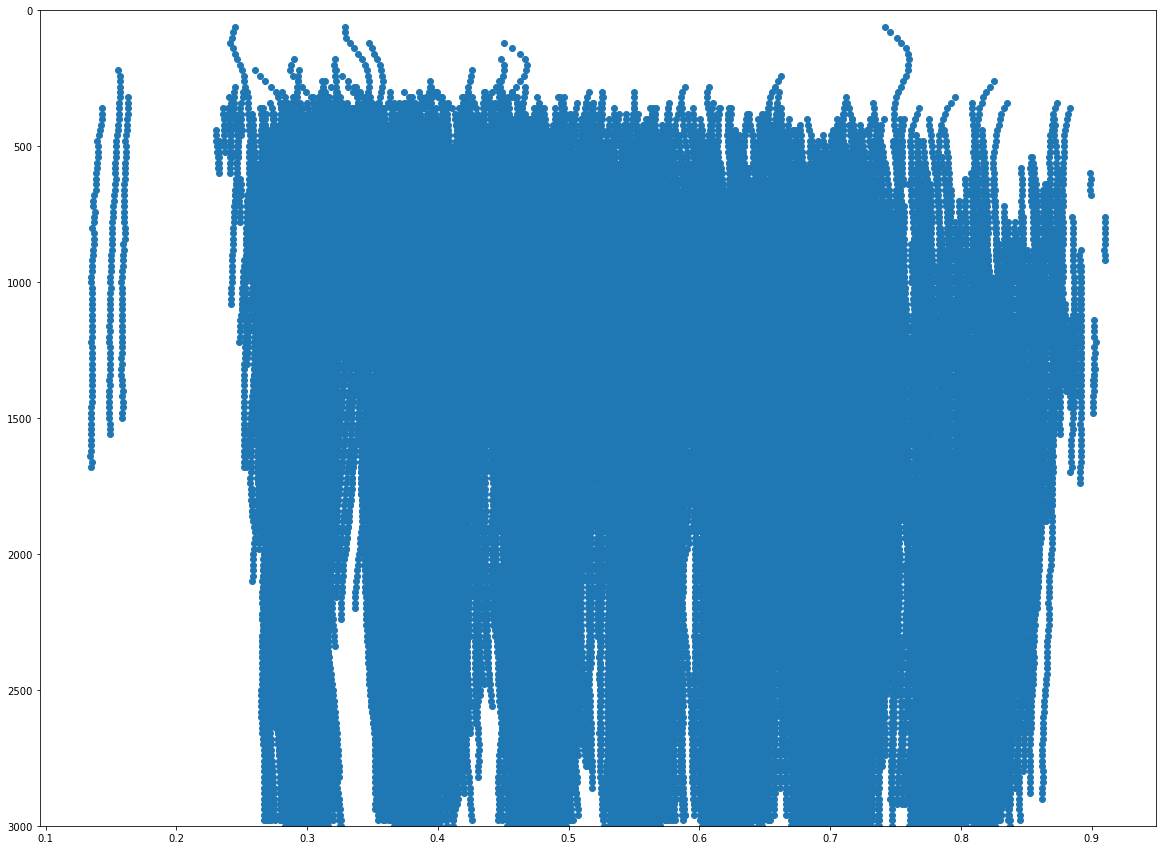

In [428]:
plt.figure(figsize=(20,15))
df = bursts
plt.scatter(df.ap_registered,df.time)
plt.ylim(3000,0)

(3000.0, 0.0)

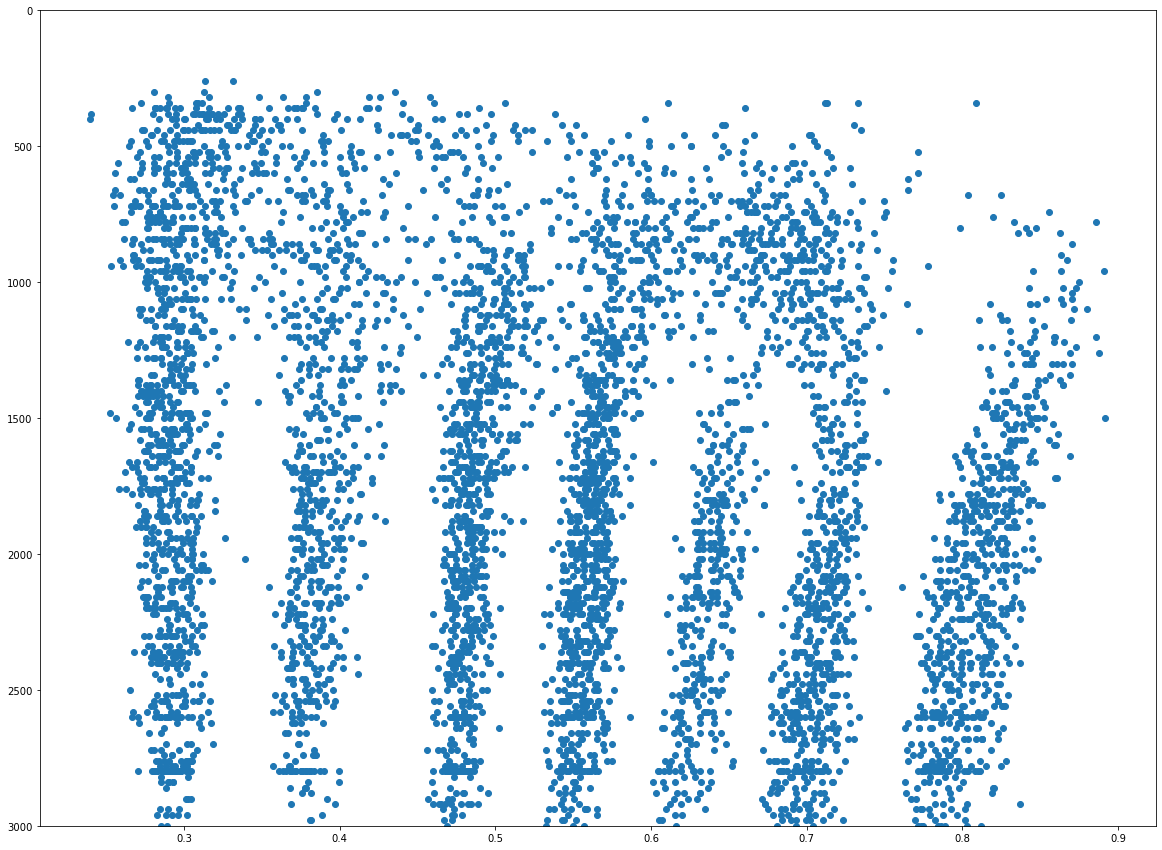

In [427]:
plt.figure(figsize=(20,15))
df = bursts[bursts.ons == 1]
plt.scatter(df.ap_registered,df.time)
plt.ylim(3000,0)

(3000.0, 0.0)

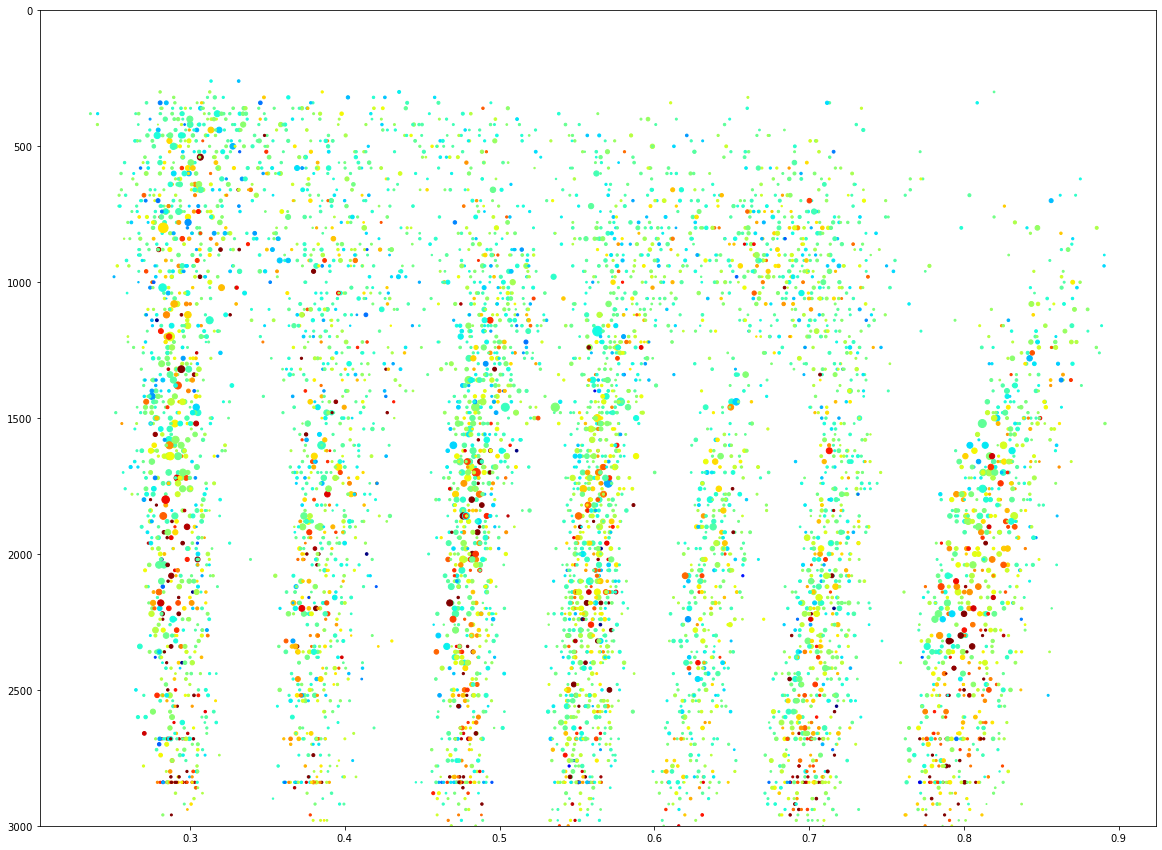

In [264]:
plt.figure(figsize=(20,15))
df = bursts[bursts.ons == 1]
plt.scatter(df.ap_registered,df.time,c=df.fluo,cmap='jet',vmin=0,vmax=200000,s=df.duration)
plt.ylim(3000,0)

(3000.0, 0.0)

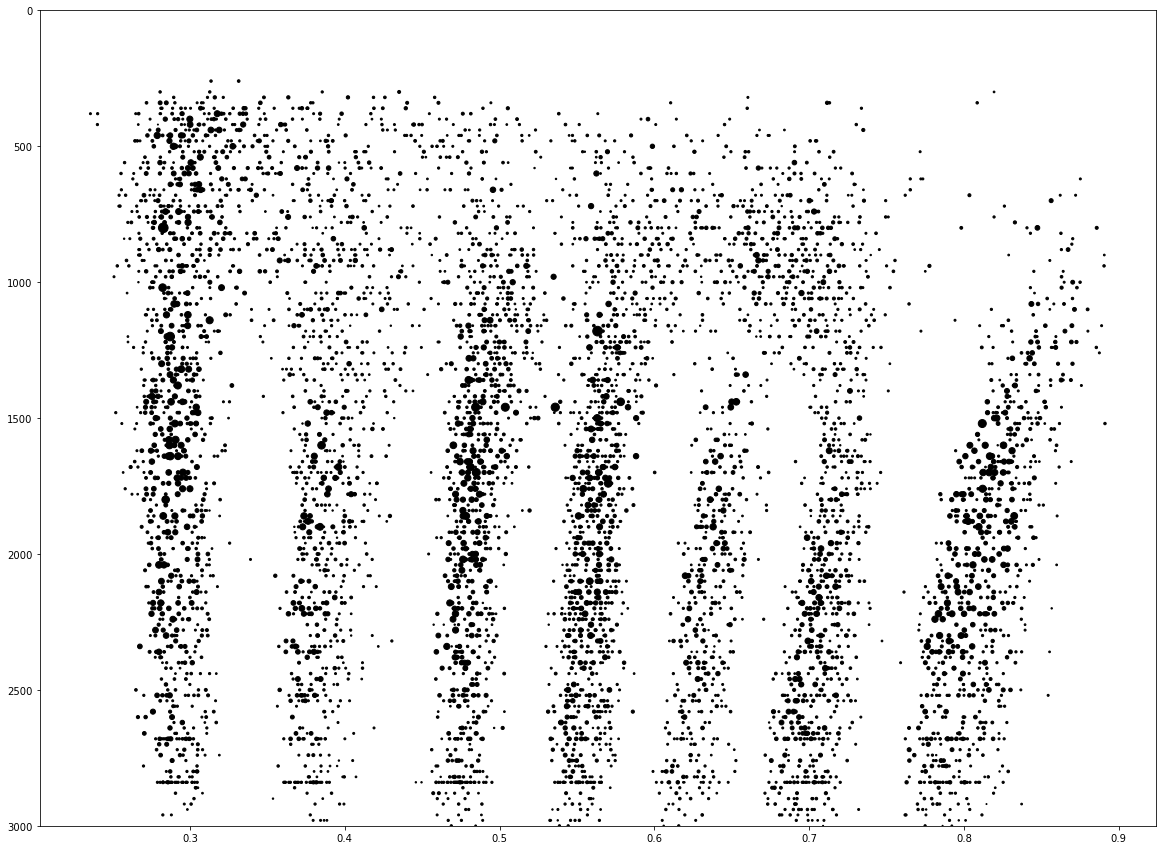

In [265]:
plt.figure(figsize=(20,15))
df = bursts[bursts.ons == 1]
plt.scatter(df.ap_registered,df.time,c='black',s=df.duration)
plt.ylim(3000,0)

In [266]:
from matplotlib.backends.backend_pdf import PdfPages

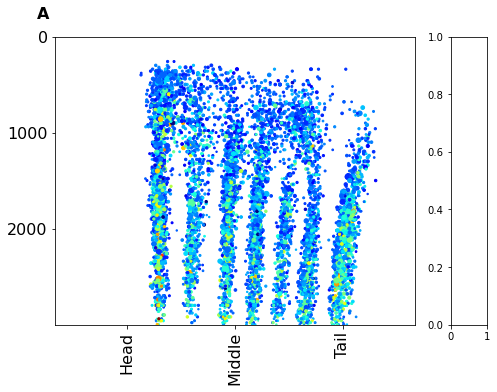

In [446]:
df = bursts[bursts.ons == 1]

pdffile = "Figure.pdf"

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh))
    
    # place panel A centered on page left-to-right and up to 1" margin on top
    panelw = 5
    panelh = 4
    
    margin_top = 1
    
    panelx = 1.0 
    panely = figh - margin_top - panelh
    
    ax1 = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    ax1.set_ylim(3000,0)
    
    labeloffset_x = .25
    labeloffset_y = .25
    
    labelx = panelx - labeloffset_x
    labely = panely + panelh + labeloffset_y
    plt.figtext(labelx/figw,labely/figh,"A", {"fontsize" : 16, "fontweight" : 'bold'})
    
    ax1.set_xlim(0,1)
    ax1.set_xticks([.2,.5,.8])
    ax1.set_xticklabels(['Head',"Middle","Tail"],rotation=90,fontsize=16)
    
    ax1.set_yticks([0,1000,2000])
    ax1.set_yticklabels(['0','1000','2000'], fontsize=16)
    
    # place panel A centered on page left-to-right and up to 1" margin on top
    
    panelw = .5
    panelh = 4
    
    margin_top = 1
    
    panelx = 1 + 5 + .5
    panely = figh - margin_top - panelh
    
    ax2 = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])    
    
    ax1.scatter(df.ap_registered,df.time,s=df.duration,c=df.fluo,cmap='jet')

    pdf.savefig()
    
    